In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as PDEModel #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.models import AdjointSimpleODEModel as ODEModel #Model module builds basic pa
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Generate Observations Using Physical Model

### Generate Training and Testing Sensor Locations

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,9,5) # lower time
xloc=np.linspace(1.5,7.5,4) # x locations
yloc=np.linspace(1.5,7.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

### Run Forward Model to Compute Concentration

In [47]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
u=[]
#u.append(np.ones(res)*wind) #x direction wind
#u.append(np.ones(res)*0.0) # y direction wind

u.append(np.ones(res)*0.01) #x direction wind
u.append(np.ones(res)*0.01) # y direction wind
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=(m.computeSourceFromPhi(z))# Compute source
#source[source<0]=0

#source = np.zeros(m.resolution)
##source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
#source[:,15:25,15:25] = 5
#source[:,2:7,2:7] = 25
#source[:,7:12,15:20] = 25
#source[:,18:28,10:20] = 25

### Generate Training and Testing Data

In [48]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations()

# Inverse Problem

In [49]:
N_feat =100 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,u=u,k_0=k_0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio

mODE = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k2,sensormodel=sensors) #Initiate new model for inference
regressODE = mODE.computeModelRegressors() # Compute regressor matrix
meanZODE, covZODE = mODE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceODE = mODE.computeSourceFromPhi(meanZODE) # Generates estimated source using inferred distribution

Calculating Adjoints...
47/48 
Calculating Phis...
99/100 
Calculating Adjoints...
47/48 
Calculating Phis...
99/100 


# Plot Mean Sources for Comparison

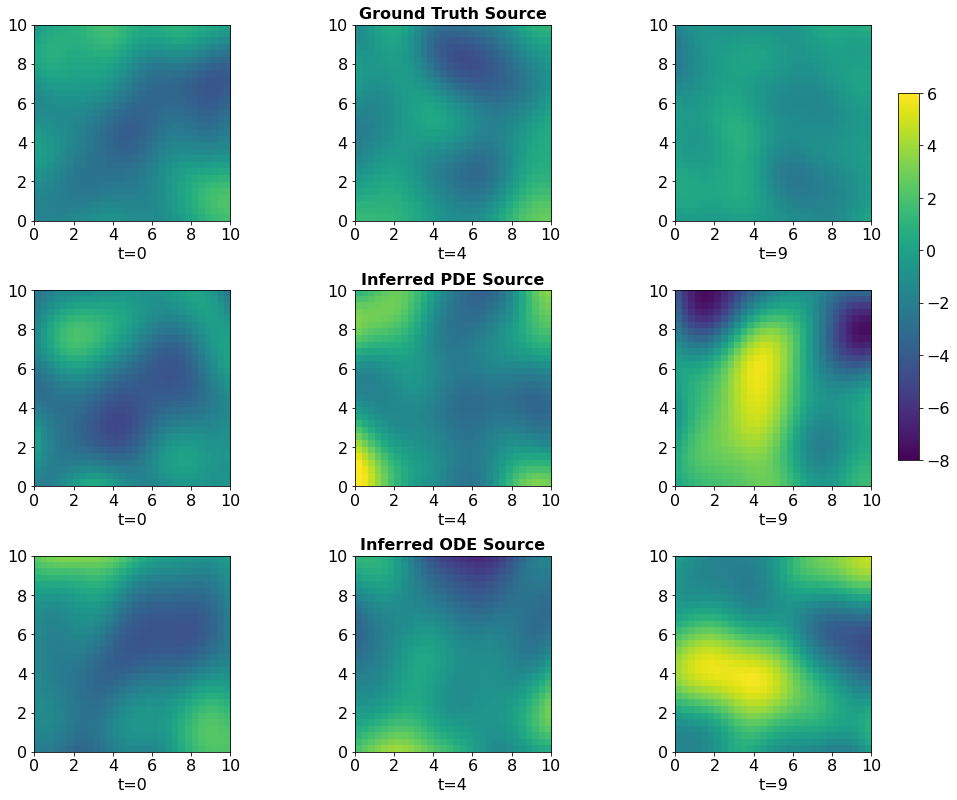

In [50]:
a=np.floor(np.min((np.min(sourceODE),np.min(sourceGT),np.min(sourcePDE))))
b=np.ceil(np.max((np.max(sourceODE),np.max(sourceGT),np.min(sourcePDE))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source','Inferred PDE Source','Inferred ODE Source'],[sourceGT,sourcePDE,sourceODE]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(3,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 0.95])

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.97, 0.52, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

In [51]:
ODEConcentration=mODE.computeConcentration(sourceODE)
PDEConcentration=mPDE.computeConcentration(sourcePDE)

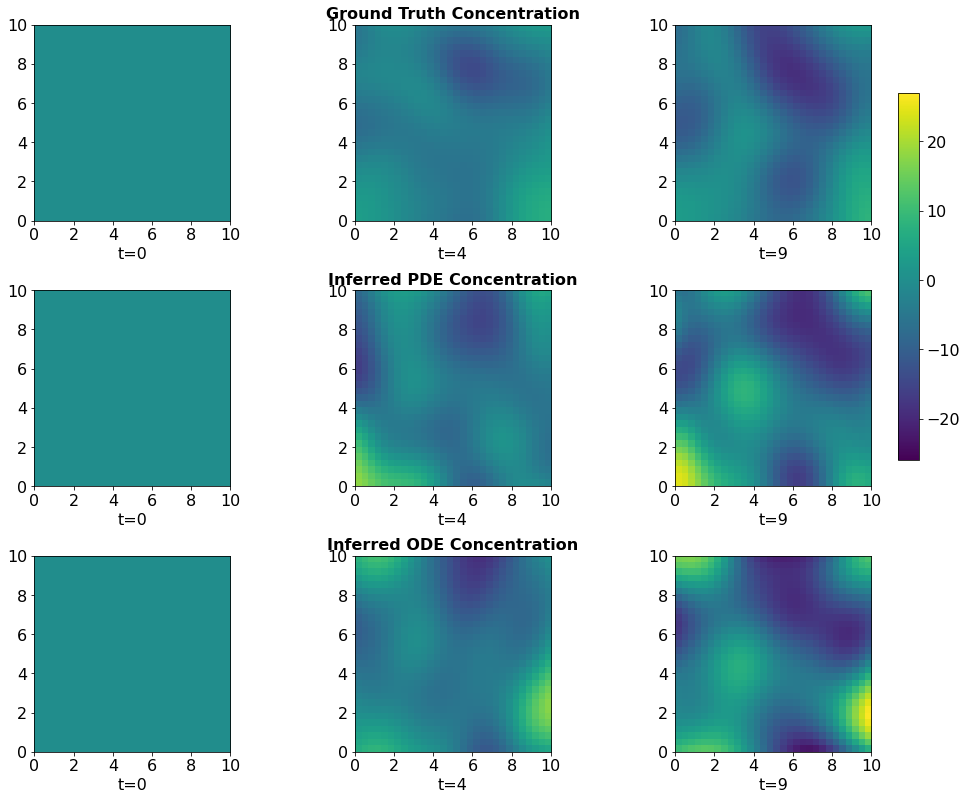

In [52]:
a=np.floor(np.min((np.min(concTrain),np.min(ODEConcentration),np.min(PDEConcentration))))
b=np.ceil(np.max((np.max(concTrain),np.max(ODEConcentration),np.min(PDEConcentration))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Concentration','Inferred PDE Concentration','Inferred ODE Concentration'],[concTrain,PDEConcentration,ODEConcentration]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(3,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 0.95])

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.97, 0.52, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

In [53]:
reps=100
llObsPDE=0
llObsODE=0
MSEPDE=0
MSEODE=0
cMSEPDE=0
cMSEODE=0
negPercent=0
var = np.ones(len(yTest))*noiseSD**2
for j in range(reps):
    #mPDE.sensormodel=sensors
    z = np.random.multivariate_normal(meanZPDE,covZPDE)
    source = mPDE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    conc=mPDE.computeConcentration(source) # Compute test concentration
    mPDE.sensormodel=sensorsTest
    yPDE= mPDE.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObsPDE += 0.5*np.sum((np.square(np.subtract(yTest,yPDE))/var)+0.5*np.log(var))
    MSEPDE += (np.square(np.subtract(yTest,yPDE))).mean() 
    cMSEPDE += (np.square(np.subtract(conc,concTrain))).mean() 
    #mODE.sensormodel=sensors
    z = np.random.multivariate_normal(meanZODE,covZODE)
    source = mODE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    conc=mODE.computeConcentration(source) # Compute test concentration
    mODE.sensormodel=sensorsTest
    yODE= mODE.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObsODE += 0.5*np.sum((np.square(np.subtract(yTest,yODE))/var)+0.5*np.log(var))
    MSEODE += (np.square(np.subtract(yTest,yODE))).mean() 
    cMSEODE += (np.square(np.subtract(conc,concTrain))).mean() 
llObsODE = llObsODE/reps
MSEODE=MSEODE/reps
cMSEODE=cMSEODE/reps
llObsPDE = llObsPDE/reps
MSEPDE = MSEPDE/reps
cMSEPDE = cMSEPDE/reps

Results = pd.DataFrame([[llObsPDE,MSEPDE,cMSEPDE],[llObsODE,MSEODE,cMSEODE]],columns=['Log like','Data MSE','ConcMSE'],index=["PDE","ODE"])



In [54]:
Results


,Log like,Data MSE,ConcMSE
PDE,59563.778271,3.730225,16.252517
ODE,33020.024150,2.071241,15.479996
